In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ==========================================================
# MODÜL 1: DEĞİŞKEN AYRIŞTIRMA (grab_col_names)
# ==========================================================
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

# ==========================================================
# MODÜL 2: ÖZELLİK MÜHENDİSLİĞİ (create_new_features)
# ==========================================================
def create_new_features(df):
    df_new = df.copy()
    
    # 1. Klinik Skorlar ve Etkileşimler
    df_new['RPP'] = (df_new['RestingBP'] * df_new['MaxHR']) / 100
    
    # ExerciseAngina'yı sayısal işleme hazırlama
    angina_map = {'Y': 1, 'N': 0}
    
    # DTS: Duke Treadmill Score Simülasyonu
    df_new['DTS_Simulated'] = 1 - (5 * df_new['Oldpeak']) - (4 * df_new['ExerciseAngina'].map(angina_map))
    
    df_new['HR_Efficiency'] = df_new['MaxHR'] / (220 - df_new['Age'])
    df_new['Age_Oldpeak'] = df_new['Age'] * df_new['Oldpeak']

    # 2. Risk Grupları ve Kategorizasyon
    df_new['HighChol'] = (df_new['Cholesterol'] > 200).astype(int)
    
    # AgeGroup_Optimized: Yaşa dayalı risk segmentasyonu
    df_new['AgeGroup_Optimized'] = pd.cut(
        df_new['Age'], 
        bins=[0, 45, 55, 120], 
        labels=['Young', 'Middle', 'Senior+']
    )
    
    df_new['MetabolicRisk'] = ((df_new['FastingBS'] == 1) & (df_new['HighChol'] == 1)).astype(int)
    
    return df_new

# ==========================================================
# MODÜL 3: VERİ ÖN İŞLEME (Preprocessing & Leakage Protection)
# ==========================================================
def heart_data_prep(X_train, X_test):
    # Train ve Test kopyaları üzerinden işlem yapma
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # 1. Hatalı/Eksik Veri İşaretleme
    for df in [X_train_prep, X_test_prep]:
        # Kolesterol 0 değerlerini NaN yap
        df['Cholesterol_Is_Missing'] = (df['Cholesterol'] == 0).astype(int)
        df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
        # Kan Basıncı 0 değerlerini NaN yap
        df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

    # 2. Sızıntısız Doldurma (Imputation)
    # Sadece TRAIN setinden istatistikleri alıyoruz
    chol_medians = X_train_prep.groupby('Sex')['Cholesterol'].median()
    bp_median = X_train_prep['RestingBP'].median()

    # Train ve Test setlerini Train'den gelen bilgiyle doldurma
    for gender in ['M', 'F']:
        X_train_prep.loc[(X_train_prep['Sex'] == gender) & (X_train_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]
        X_test_prep.loc[(X_test_prep['Sex'] == gender) & (X_test_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]

    X_train_prep['RestingBP'] = X_train_prep['RestingBP'].fillna(bp_median)
    X_test_prep['RestingBP'] = X_test_prep['RestingBP'].fillna(bp_median)

    # 3. Encoding İşlemi
    # Önce kolonları belirle
    cat_cols, num_cols, cat_but_car = grab_col_names(X_train_prep)
    
    # One-Hot Encoding (Dummies)
    X_train_prep = pd.get_dummies(X_train_prep, columns=cat_cols, drop_first=True)
    X_test_prep = pd.get_dummies(X_test_prep, columns=cat_cols, drop_first=True)

    # Kolon eşitleme (Train'de olup Test'te olmayan kolonları 0 ile doldur)
    X_test_prep = X_test_prep.reindex(columns=X_train_prep.columns, fill_value=0)

    return X_train_prep, X_test_prep

# ==========================================================
# MODÜL 4: FINAL PIPELINE
# ==========================================================
def run_final_pipeline(df, target="HeartDisease"):
    # 1. Özellik Mühendisliği (Bütün veriye uygulanabilir çünkü satır bazlıdır)
    df_enriched = create_new_features(df)
    
    # 2. Train-Test Ayırma
    y = df_enriched[target]
    X = df_enriched.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
    
    # 3. Ön İşleme (Sızıntı korumalı)
    X_train_prep, X_test_prep = heart_data_prep(X_train, X_test)
    
    # 4. Standartlaştırma (Sayısal kolonlar için)
    num_cols = X_train_prep.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_train_prep[num_cols] = scaler.fit_transform(X_train_prep[num_cols])
    X_test_prep[num_cols] = scaler.transform(X_test_prep[num_cols])
    
    # 5. Model Eğitimi (XGBoost)
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_prep, y_train)
    
    # 6. Sonuçlar
    y_pred = model.predict(X_test_prep)
    print("\n--- FINAL PIPELINE SONUÇLARI ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return model

# ÇALIŞTIRMA:
def load():
    data = pd.read_csv("dataset/heart.csv")
    return data
df = load()
final_model = run_final_pipeline(df)

C:\Users\VICTUS\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [03:25:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- FINAL PIPELINE SONUÇLARI ---
Accuracy: 0.8641

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85        82
           1       0.87      0.88      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



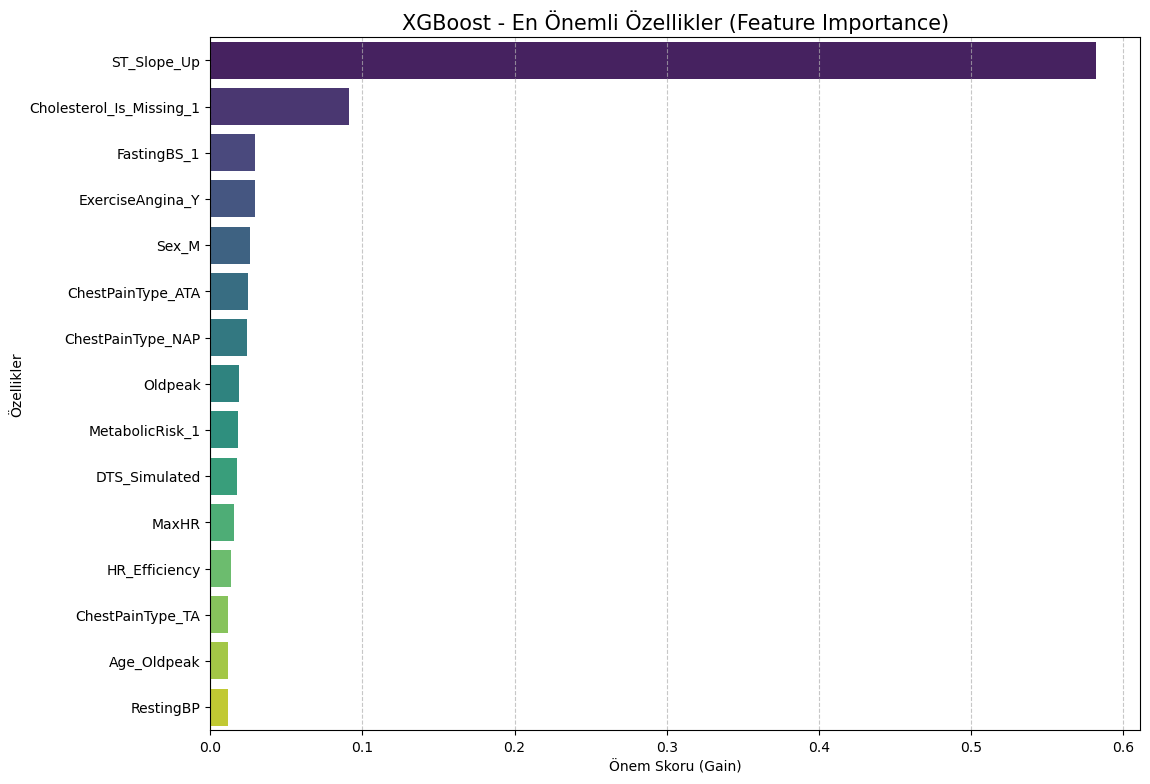

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pipeline'ı Çalıştır (Modeli al)
#final_model = run_final_pipeline(df)

# 2. Görselleştirme için kolon isimlerini hazırlama
X_enriched = create_new_features(df)
X_features = X_enriched.drop("HeartDisease", axis=1)
y_target = df["HeartDisease"]

# Train-test ayırıyoruz
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_features, y_target, test_size=0.2, stratify=y_target, random_state=42
)

# DİKKAT: Buradaki fonksiyon 2 değer döndürdüğü için 2 değişkene atıyoruz
X_train_final, X_test_final = heart_data_prep(X_temp_train, X_temp_test)

# 3. Özellik Önemini Çizdirme
def plot_importance(model, features_df):
    importances = model.feature_importances_
    feature_names = features_df.columns
    
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 9))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
    plt.title('XGBoost - En Önemli Özellikler (Feature Importance)', fontsize=15)
    plt.xlabel('Önem Skoru (Gain)')
    plt.ylabel('Özellikler')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Grafiği çalıştır
plot_importance(final_model, X_train_final)

# Deneme

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ==========================================================
# MODÜL 1: DEĞİŞKEN AYRIŞTIRMA (grab_col_names)
# ==========================================================
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

# ==========================================================
# MODÜL 2: ÖZELLİK MÜHENDİSLİĞİ (create_new_features)
# ==========================================================

# ==========================================================
# MODÜL 3: VERİ ÖN İŞLEME (Preprocessing & Leakage Protection)
# ==========================================================
def heart_data_prep(X_train, X_test):
    # Train ve Test kopyaları üzerinden işlem yapma
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # 1. Hatalı/Eksik Veri İşaretleme
    for df in [X_train_prep, X_test_prep]:
        # Kolesterol 0 değerlerini NaN yap
        df['Cholesterol_Is_Missing'] = (df['Cholesterol'] == 0).astype(int)
        df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
        # Kan Basıncı 0 değerlerini NaN yap
        df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

    # 2. Sızıntısız Doldurma (Imputation)
    # Sadece TRAIN setinden istatistikleri alıyoruz
    chol_medians = X_train_prep.groupby('Sex')['Cholesterol'].median()
    bp_median = X_train_prep['RestingBP'].median()

    # Train ve Test setlerini Train'den gelen bilgiyle doldurma
    for gender in ['M', 'F']:
        X_train_prep.loc[(X_train_prep['Sex'] == gender) & (X_train_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]
        X_test_prep.loc[(X_test_prep['Sex'] == gender) & (X_test_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]

    X_train_prep['RestingBP'] = X_train_prep['RestingBP'].fillna(bp_median)
    X_test_prep['RestingBP'] = X_test_prep['RestingBP'].fillna(bp_median)

    # 3. Encoding İşlemi
    # Önce kolonları belirle
    cat_cols, num_cols, cat_but_car = grab_col_names(X_train_prep)
    
    # One-Hot Encoding (Dummies)
    X_train_prep = pd.get_dummies(X_train_prep, columns=cat_cols, drop_first=True)
    X_test_prep = pd.get_dummies(X_test_prep, columns=cat_cols, drop_first=True)

    # Kolon eşitleme (Train'de olup Test'te olmayan kolonları 0 ile doldur)
    X_test_prep = X_test_prep.reindex(columns=X_train_prep.columns, fill_value=0)

    return X_train_prep, X_test_prep

# ==========================================================
# MODÜL 4: FINAL PIPELINE
# ==========================================================
def run_final_pipeline(df, target="HeartDisease"):
    # 1. Özellik Mühendisliği (Bütün veriye uygulanabilir çünkü satır bazlıdır)
    df_enriched = df
    
    # 2. Train-Test Ayırma
    y = df_enriched[target]
    X = df_enriched.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
    
    # 3. Ön İşleme (Sızıntı korumalı)
    X_train_prep, X_test_prep = heart_data_prep(X_train, X_test)
    
    # 4. Standartlaştırma (Sayısal kolonlar için)
    num_cols = X_train_prep.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_train_prep[num_cols] = scaler.fit_transform(X_train_prep[num_cols])
    X_test_prep[num_cols] = scaler.transform(X_test_prep[num_cols])
    
    # 5. Model Eğitimi (XGBoost)
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_prep, y_train)
    
    # 6. Sonuçlar
    y_pred = model.predict(X_test_prep)
    print("\n--- FINAL PIPELINE SONUÇLARI ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return model

# ÇALIŞTIRMA:
def load():
    data = pd.read_csv("dataset/heart.csv")
    return data
df = load()
final_model = run_final_pipeline(df)

C:\Users\VICTUS\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [04:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- FINAL PIPELINE SONUÇLARI ---
Accuracy: 0.8696

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86        82
           1       0.90      0.86      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



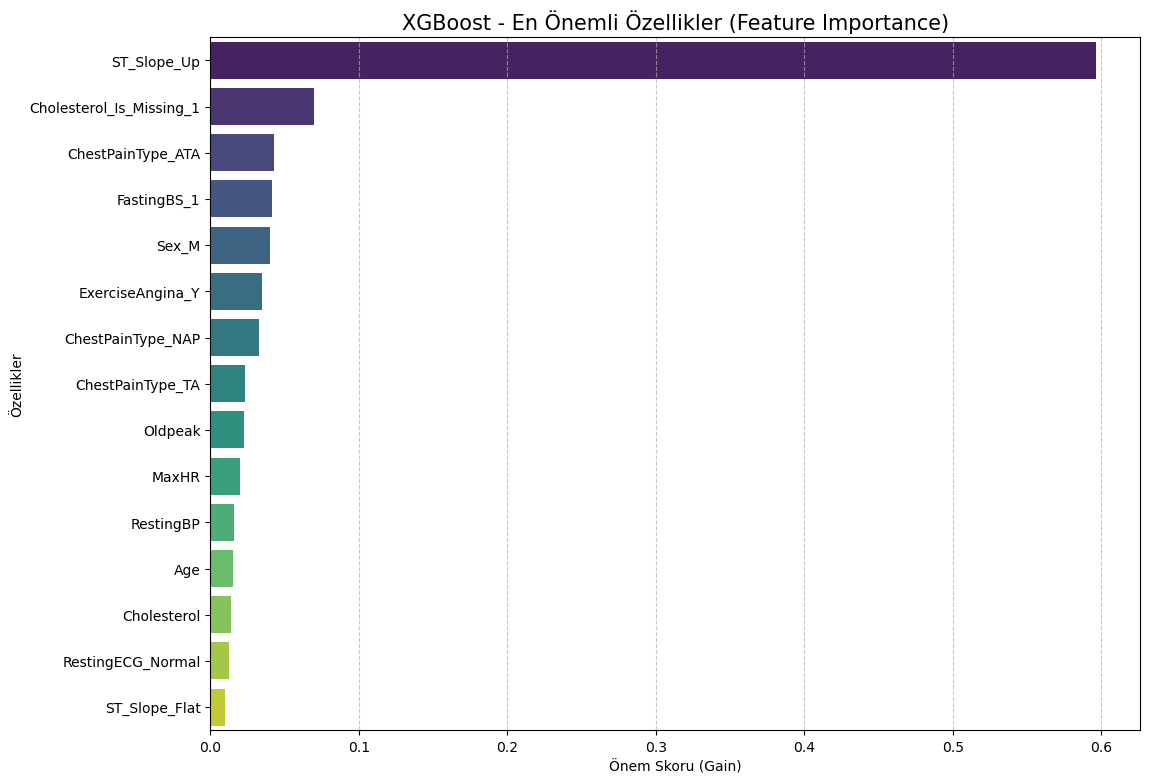

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pipeline'ı Çalıştır (Modeli al)
#final_model = run_final_pipeline(df)

# 2. Görselleştirme için kolon isimlerini hazırlama
X_enriched = df
X_features = X_enriched.drop("HeartDisease", axis=1)
y_target = df["HeartDisease"]

# Train-test ayırıyoruz
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_features, y_target, test_size=0.2, stratify=y_target, random_state=42
)

# DİKKAT: Buradaki fonksiyon 2 değer döndürdüğü için 2 değişkene atıyoruz
X_train_final, X_test_final = heart_data_prep(X_temp_train, X_temp_test)

# 3. Özellik Önemini Çizdirme
def plot_importance(model, features_df):
    importances = model.feature_importances_
    feature_names = features_df.columns
    
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 9))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), palette='viridis')
    plt.title('XGBoost - En Önemli Özellikler (Feature Importance)', fontsize=15)
    plt.xlabel('Önem Skoru (Gain)')
    plt.ylabel('Özellikler')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Grafiği çalıştır
plot_importance(final_model, X_train_final)